**STL-10 ex_3**

Submitted by :

Ahigad Genish 316228022

Omer Sela 316539535


Use different types of deep learning models for classify STL-10 images.

How to run the Code ?

Run all sections from the begining, the first part is visualiaing the data.

Prerequisites -

Use GPU and run first section to dowanload data and install relevant packages

Part 1 -

Run and the images of the classes will appear. - Visualize the data

Part 2 -

In each subpart we define a model. Run each section.
Afterwards, run the train, test and the relevant model you would like to train and test .Finally, compare the performance of each model on the STL-10 data



***Prerequisites***

Import relevant packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split

Set device settings

In [4]:
batch_size = 128
val_size = 0.2 # 20% of the training set will be used as validation

# Set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

cuda = True
use_cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device in use: " , device)
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.enabled = use_cuda
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Device in use:  cuda


Download data

In [5]:
# transform data: scaling, augmentation, ...
mean = (0.1, 0.1, 0.1)
std =  (0.85, 0.85, 0.85)

train_transform = transforms.Compose([
        transforms.RandomCrop(size=(64,64)), # Randomly crop the image, results in a size of 64x64
        transforms.RandomRotation(degrees=15), # Randomly rotates the images up to 15 degrees
        transforms.RandomHorizontalFlip(p=0.5), # Randomly flips the image horizontally
        transforms.ToTensor(),  # Convert a PIL Image or numpy.ndarray to tensor
        transforms.Normalize(mean, std) # image = (image - mean) / std
        ])

test_transform = transforms.Compose([
        transforms.CenterCrop(size=(64,64)),
        transforms.ToTensor(),  # Convert a PIL Image or numpy.ndarray to tensor
        transforms.Normalize(mean, std) # image = (image - mean) / std
        ])

train = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform=train_transform)

# The validation set takes from the train set, but using the test's transformation
val = torchvision.datasets.STL10(root='./data', split='train',
                                     download=True, transform=test_transform)
test = torchvision.datasets.STL10(root='./data', split='test',
                                      download=True, transform=test_transform)

# Since both the train and validation set has the full training set, we will need to randomly pick data points for each of them
rand_indx = np.random.choice(a=len(train),size=len(train),replace=False)

val_sampler = torch.utils.data.SubsetRandomSampler(rand_indx[:int(np.floor(len(rand_indx)*val_size))])
train_sampler = torch.utils.data.SubsetRandomSampler(rand_indx[int(np.floor(len(rand_indx)*val_size)):])


train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                           num_workers=4, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                         num_workers=3, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

100%|██████████| 2640397119/2640397119 [06:19<00:00, 6965193.05it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


# Part 1

Visualize the data

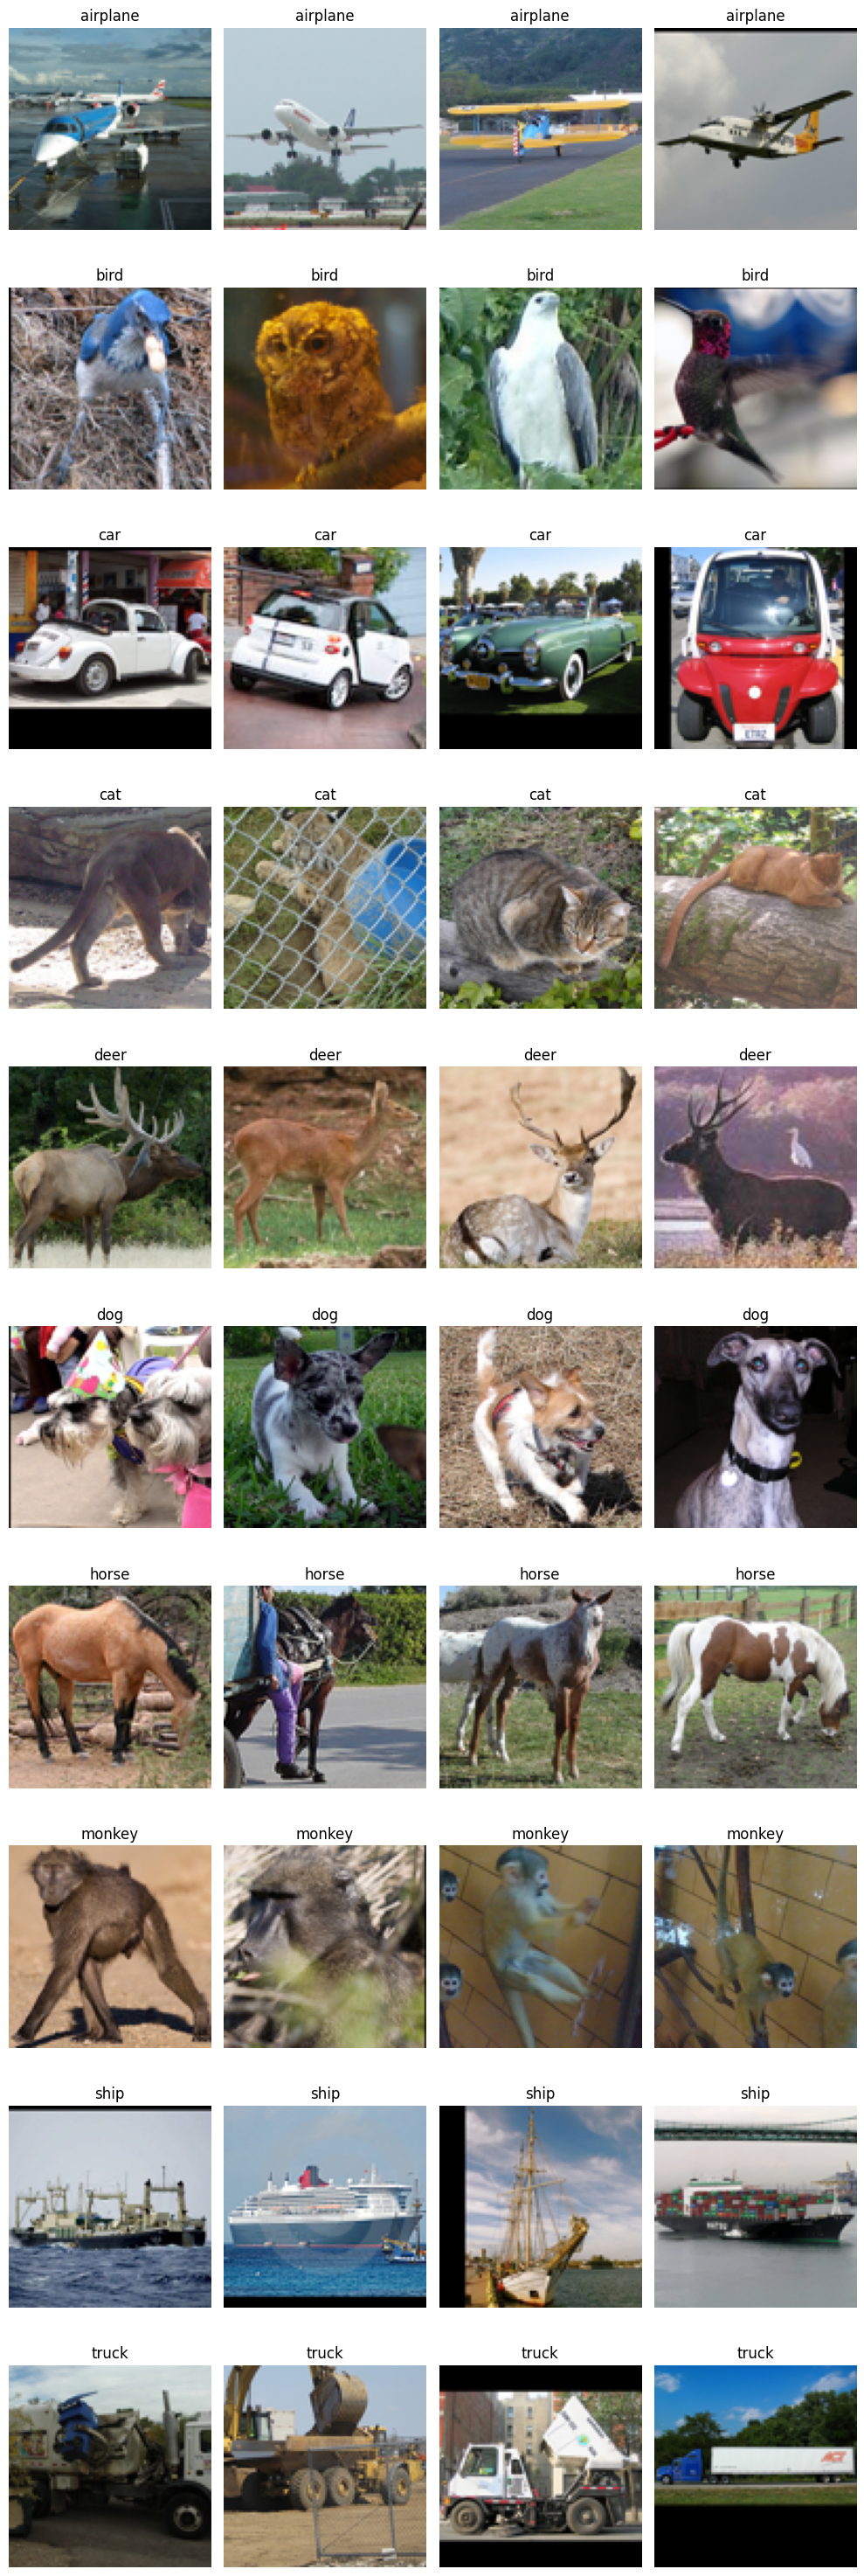

In [19]:
# Randomly shuffle the indices
random_indices = np.random.permutation(len(train.data))

plt.figure(figsize=(10, 30))

for label_num in range(10):
    # Initialize counter for images per class
    count = 0
    for idx in random_indices:
        if train.labels[idx] == label_num:
            # Plot the image
            plt.subplot(10, 4, label_num * 4 + count + 1)
            plt.title(train.classes[label_num])
            plt.imshow(train.data[idx].transpose(1, 2, 0))
            plt.axis('off')
            count += 1
        if count >= 4:  # Plot only 4 images per class
            break

plt.tight_layout()
plt.show()

# Augmentation Example
Example of rotation and horizontal flip:


Files already downloaded and verified


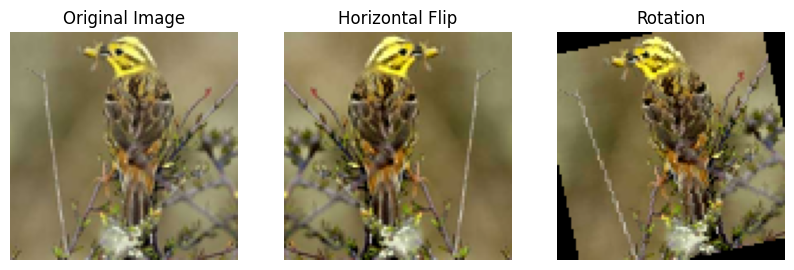

In [20]:
# Load an example image from the STL10 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the dataset without any transformations
dataset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)

# Select a random image from the dataset
index = 0  # Change this index to select a different image
image, _ = dataset[index]

# Define transformations to apply
mean = (0.1, 0.1, 0.1)
std = (0.85, 0.85, 0.85)
horizontal_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),  # Always flip horizontally
    transforms.Normalize(mean, std)
])
rotation = transforms.Compose([
    transforms.RandomRotation(degrees=15),   # Rotate the image up to 15 degrees
    transforms.Normalize(mean, std)
])

# Apply transformations to the original image
image_horizontal_flip = horizontal_flip(image)
image_rotation = rotation(image)

# Display the original image along with the transformed images
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image.permute(1, 2, 0))  # Convert tensor to numpy array and rearrange dimensions
plt.axis('off')

# Image after horizontal flip
plt.subplot(1, 3, 2)
plt.title('Horizontal Flip')
plt.imshow(image_horizontal_flip.permute(1, 2, 0))  # Convert tensor to numpy array and rearrange dimensions
plt.axis('off')

# Image after rotation
plt.subplot(1, 3, 3)
plt.title('Rotation')
plt.imshow(image_rotation.permute(1, 2, 0))  # Convert tensor to numpy array and rearrange dimensions
plt.axis('off')

plt.show()

#Part 2

#2.1  : Logistic Regression

In [21]:
class LogisticRegression(nn.Module):

    def __init__(self, image_size=64*64*3,num_of_classes=10):
        super(LogisticRegression, self).__init__()
        self.flat = nn.Flatten(start_dim=1) # Makes a 1d representation of the image
        self.fc = nn.Linear(image_size, num_of_classes) # A fully connected linear layer

    def forward(self, x):
        x = self.flat(x)
        x = self.fc(x)
        return x

#2.2 : Fully Connected Neural Network (FCNN)

In [22]:
class FCNN(nn.Module):

    def __init__(self):
        super(FCNN, self).__init__() # 5 layers
        self.flat = nn.Flatten(start_dim=1) # Makes a 1d representation of the image
        self.fc1 = nn.Linear(64 * 64 * 3, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.d1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.d2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.d3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.d4 = nn.Dropout(p=0.5)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flat(x)
        x = self.d1(F.relu(self.bn1(self.fc1(x))))
        x = self.d2(F.relu(self.bn2(self.fc2(x))))
        x = self.d3(F.relu(self.bn3(self.fc3(x))))
        x = self.d4(F.relu(self.bn4(self.fc4(x))))
        x = self.out(x)
        return x

#2.3 : CNN

In [43]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        # shape: 64*64 -> 62*62
        self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)
        # shape: 62*62 -> 31*31
        self.conv2 = nn.Conv2d(8, 32, 3)
        # shape: 31*31 -> 29*29
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        # shape: 29*29 -> 14*14
        self.conv3 = nn.Conv2d(32, 64, 3)
        # shape: 14*14 -> 12*12
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)
        # shape: 12*12 -> 6*6
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # x.shape = [64, 8, 31, 31]
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # x.shape = [64, 32, 15, 15]
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # x.shape = [64, 64, 7, 7]
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 2.4 Fixed MobileNetV2

In [6]:
class MobileNetV2_Fixed(nn.Module):

    def __init__(self):
        super(MobileNetV2_Fixed, self).__init__()
        self.feature_extractor = models.mobilenet_v2(pretrained=True)

        for param in self.feature_extractor.parameters():
            param.requires_grad = False # Doesn't update the networks parameters
        # The Output layer has a FC layer with an output of 1,000
        self.d1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(self.feature_extractor.classifier[1].out_features, 512)
        self.d2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, 64) # output size: 20
        self.d3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(64, 10) # classifier layer: output size: 10

    def forward(self, x):
        x = self.feature_extractor(x) # Pass the input through the original netweork
        x = self.d1(F.relu(x))
        x = self.d2(F.relu(self.fc2(x)))
        x = self.d3(F.relu(self.fc3(x)))
        output = self.fc4(x)
        return output

2.5 : Learned pre-trained MobileNetV2




In [7]:
class MobileNetV2_Learned(nn.Module):

    def __init__(self):
        super(MobileNetV2_Learned, self).__init__()
        self.feature_extractor = models.mobilenet_v2(pretrained=True)

        for param in self.feature_extractor.parameters():
            param.requires_grad = True # Updates the networks parameters
        # The Output layer has a FC layer with an output of 1,000

        self.d1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(self.feature_extractor.classifier[1].out_features, 512)

        self.d2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, 64) # output size: 20

        self.d3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(64, 10) # classifier layer: output size: 10

    def forward(self, x):
        x = self.feature_extractor(x) # Pass the input through the original netweork
        x = self.d1(F.relu(x))
        x = self.d2(F.relu(self.fc2(x)))
        x = self.d3(F.relu(self.fc3(x)))
        output = self.fc4(x)

        #output = self.feature_extractor(x) # Pass the input through the altered netweork
        return output

Train

In [8]:
def train_network(model, device, batch_size, optimizer_name, learning_rate, regularization):

    # Initialize variables to store losses and accuracies
    train_losses, train_accuracy, val_losses, val_accuracy = ([] for _ in range(4))

    # Set momentum for SGD optimizer
    momentum = 0.9

    # Choose the optimizer based on the optimizer_name
    if optimizer_name == 'Adams':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=regularization)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization)
    else:
        raise ValueError("Invalid optimizer name. Choose 'Adams' or 'SGD'.")

    # Create data loaders for training and validation datasets
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=4, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=3, sampler=val_sampler)

    # Train the model for the specified number of epochs
    for epoch in range(epochs):

        # Set the model to train mode
        model.train()
        loss = 0
        accuracy = 0

        # Iterate over the training data
        for batch_idx, (pics, labels) in enumerate(train_loader):

            # Transfer data to device
            pics = pics.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(pics)

            # Compute loss
            batch_loss = criterion(logits, labels)
            loss += batch_loss.item()

            # Compute accuracy
            pred = logits.argmax(dim=1, keepdim=True)
            batch_acc = pred.eq(labels.view_as(pred)).sum().item() / pics.shape[0]
            accuracy += batch_acc

            # Backward pass
            batch_loss.backward()

            # Update weights
            optimizer.step()

        # Validate the model
        model.eval()
        val_acc, val_loss = test(model, device)

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch: {epoch + 1}\tTrain Loss: {(loss / (batch_idx + 1)):.4f}\tAccuracy: {(accuracy / (batch_idx + 1)):.4f}', end=' || ')
            print(f'Validation Loss: {val_loss:.4f}\tAccuracy: {val_acc:.4f}')

        # Save losses and accuracies for plotting
        train_losses.append(loss / (batch_idx + 1))
        val_losses.append(val_loss)
        train_accuracy.append(accuracy / (batch_idx + 1))
        val_accuracy.append(val_acc)

    return model, train_losses, val_losses, train_accuracy, val_accuracy

Test

In [9]:
def test(model, device):

    # Set the model to evaluation mode
    model.eval()

    # Define the loss criterion
    criterion = nn.CrossEntropyLoss()

    # Initialize variables to calculate accuracy and loss
    correct = 0
    total = 0
    num_of_batches = 0
    test_loss = 0

    # Disable gradient calculation during testing
    with torch.no_grad():

        # Iterate through the test data loader
        for pic in test_loader:

            # Increment the batch counter
            num_of_batches += 1

            # Extract images and labels from the batch
            images, labels = pic

            # Move images and labels to the device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Accumulate the test loss
            test_loss += loss.item()

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the average test accuracy and loss
    test_accuracy = correct / total
    test_loss /= num_of_batches

    # Return the test accuracy and loss
    return test_accuracy, test_loss

Main

Hyper Parameters

In [10]:
# Parameters
epochs = 40   # # Due to limited resources only check ephocs = 40
criterion = nn.CrossEntropyLoss()
momentum = 0.9


lr = [0.0001, 0.0005, 0.001]
optimizers = ["Adams", "SGD"]
regularization = [0.0001] # Due to limited resources only check weigth_decay = 0.0001
batch_size = [128] # Due to limites resources only check batch_size = 128

Logistic Regression

****************************************************************************************************
Testing hyperparameters: learning_rate=0.0001, optimizer=Adams, regularization=0.0001, batch_size=128
Epoch: 1	Train Loss: 2.2352	Accuracy: 0.1653 || Validation Loss: 2.1260	Accuracy: 0.2069
Epoch: 11	Train Loss: 2.0749	Accuracy: 0.2410 || Validation Loss: 2.0703	Accuracy: 0.2319
Epoch: 21	Train Loss: 2.0471	Accuracy: 0.2485 || Validation Loss: 2.0568	Accuracy: 0.2589
Epoch: 31	Train Loss: 2.0386	Accuracy: 0.2622 || Validation Loss: 2.0338	Accuracy: 0.2656
****************************************************************************************************
Testing hyperparameters: learning_rate=0.0001, optimizer=SGD, regularization=0.0001, batch_size=128
Epoch: 1	Train Loss: 2.2922	Accuracy: 0.1357 || Validation Loss: 2.2486	Accuracy: 0.1598
Epoch: 11	Train Loss: 2.1042	Accuracy: 0.2205 || Validation Loss: 2.0792	Accuracy: 0.2359
Epoch: 21	Train Loss: 2.0927	Accuracy: 0.2373 || Validatio

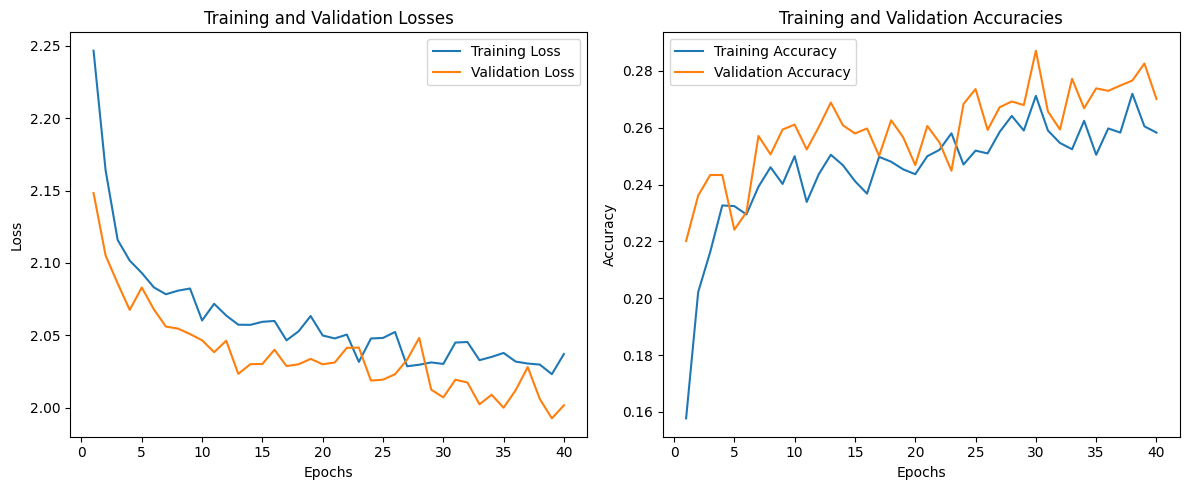

In [29]:
best_accuracy = 0
best_hyperparameters = {}
best_train_losses, best_val_losses, best_train_accuracy, best_val_accuracy = [], [], [], []

# Iterate over different parameters
for learning_rate in lr:
    for optimizer_name in optimizers:
        for reg in regularization:
            for batch_size_val in batch_size:

                print("*" * 100)
                print(f"Testing hyperparameters: learning_rate={learning_rate}, optimizer={optimizer_name}, regularization={reg}, batch_size={batch_size_val}")

                # Initialize the model
                model = LogisticRegression().to(device)

                # Train the model
                trained_model, train_losses, val_losses, train_accuracy, val_accuracy = train_network(model, device, batch_size_val, optimizer_name, learning_rate, reg)

                # Evaluate on validation set
                val_acc, val_loss = test(trained_model, device)

                # Update best accuracy and hyperparameters if current model has higher accuracy
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_hyperparameters = {
                        "learning_rate": learning_rate,
                        "optimizer": optimizer_name,
                        "regularization": reg,
                        "batch_size": batch_size_val
                    }
                    best_train_losses = train_losses
                    best_val_losses = val_losses
                    best_train_accuracy = train_accuracy
                    best_val_accuracy = val_accuracy

# Print the best hyperparameters and accuracy
print("Best hyperparameters:", best_hyperparameters)
print("Best validation accuracy:", best_accuracy)

# Plot the best graph
epochs_range = range(1, len(best_train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, best_train_losses, label='Training Loss')
plt.plot(epochs_range, best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, best_train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, best_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


FCNN

****************************************************************************************************
Testing hyperparameters: learning_rate=0.0001, optimizer=Adams, regularization=0.0001, batch_size=128
Epoch: 1	Train Loss: 2.4009	Accuracy: 0.1116 || Validation Loss: 2.2676	Accuracy: 0.1588
Epoch: 11	Train Loss: 2.2093	Accuracy: 0.1816 || Validation Loss: 2.0916	Accuracy: 0.2427
Epoch: 21	Train Loss: 2.1113	Accuracy: 0.2080 || Validation Loss: 2.0194	Accuracy: 0.2600
Epoch: 31	Train Loss: 2.0557	Accuracy: 0.2341 || Validation Loss: 1.9572	Accuracy: 0.2804
****************************************************************************************************
Testing hyperparameters: learning_rate=0.0001, optimizer=SGD, regularization=0.0001, batch_size=128
Epoch: 1	Train Loss: 2.4451	Accuracy: 0.1016 || Validation Loss: 2.3013	Accuracy: 0.1123
Epoch: 11	Train Loss: 2.3690	Accuracy: 0.1206 || Validation Loss: 2.2504	Accuracy: 0.1855
Epoch: 21	Train Loss: 2.3406	Accuracy: 0.1277 || Validatio

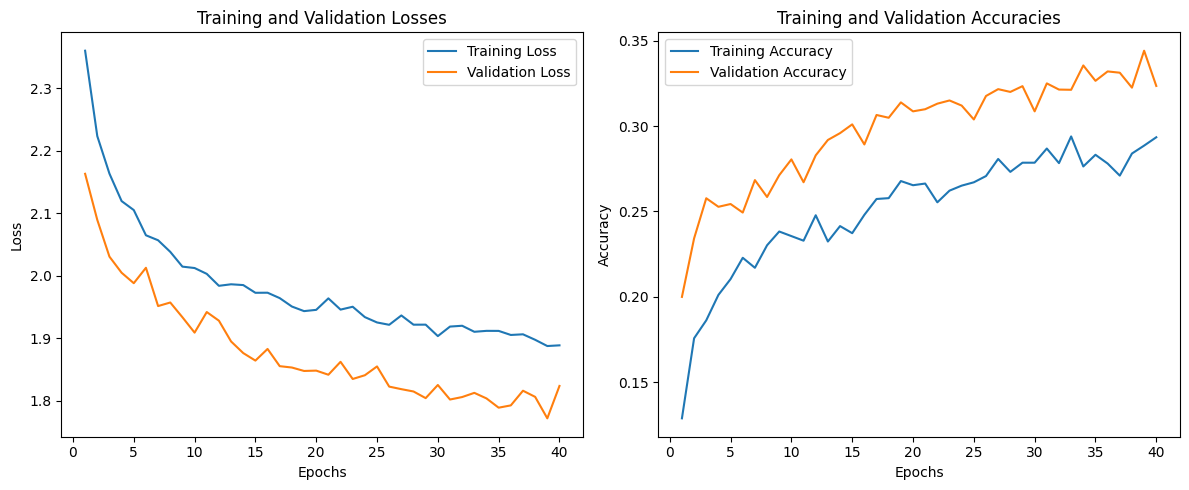

In [30]:
best_accuracy = 0
best_hyperparameters = {}
best_train_losses, best_val_losses, best_train_accuracy, best_val_accuracy = [], [], [], []

# Iterate over different parameters
for learning_rate in lr:
    for optimizer_name in optimizers:
        for reg in regularization:
            for batch_size_val in batch_size:

                print("*" * 100)
                print(f"Testing hyperparameters: learning_rate={learning_rate}, optimizer={optimizer_name}, regularization={reg}, batch_size={batch_size_val}")

                # Initialize the model
                model = FCNN().to(device)

                # Train the model
                trained_model, train_losses, val_losses, train_accuracy, val_accuracy = train_network(model, device, batch_size_val, optimizer_name, learning_rate, reg)

                # Evaluate on validation set
                val_acc, val_loss = test(trained_model, device)

                # Update best accuracy and hyperparameters if current model has higher accuracy
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_hyperparameters = {
                        "learning_rate": learning_rate,
                        "optimizer": optimizer_name,
                        "regularization": reg,
                        "batch_size": batch_size_val
                    }
                    best_train_losses = train_losses
                    best_val_losses = val_losses
                    best_train_accuracy = train_accuracy
                    best_val_accuracy = val_accuracy

# Print the best hyperparameters and accuracy
print("Best hyperparameters:", best_hyperparameters)
print("Best validation accuracy:", best_accuracy)

# Plot the best graph
epochs_range = range(1, len(best_train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, best_train_losses, label='Training Loss')
plt.plot(epochs_range, best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, best_train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, best_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

CNN

****************************************************************************************************
Testing hyperparameters: learning_rate=0.0001, optimizer=Adams, regularization=0.0001, batch_size=128
Epoch: 1	Train Loss: 2.1556	Accuracy: 0.2053 || Validation Loss: 2.1925	Accuracy: 0.2120
Epoch: 11	Train Loss: 1.5434	Accuracy: 0.4233 || Validation Loss: 1.4512	Accuracy: 0.4656
Epoch: 21	Train Loss: 1.4252	Accuracy: 0.4714 || Validation Loss: 1.3752	Accuracy: 0.4916
Epoch: 31	Train Loss: 1.3539	Accuracy: 0.5095 || Validation Loss: 1.2907	Accuracy: 0.5341
****************************************************************************************************
Testing hyperparameters: learning_rate=0.0001, optimizer=SGD, regularization=0.0001, batch_size=128
Epoch: 1	Train Loss: 2.3255	Accuracy: 0.1077 || Validation Loss: 2.3030	Accuracy: 0.1045
Epoch: 11	Train Loss: 2.1207	Accuracy: 0.2122 || Validation Loss: 2.0959	Accuracy: 0.2495
Epoch: 21	Train Loss: 1.9928	Accuracy: 0.2744 || Validatio

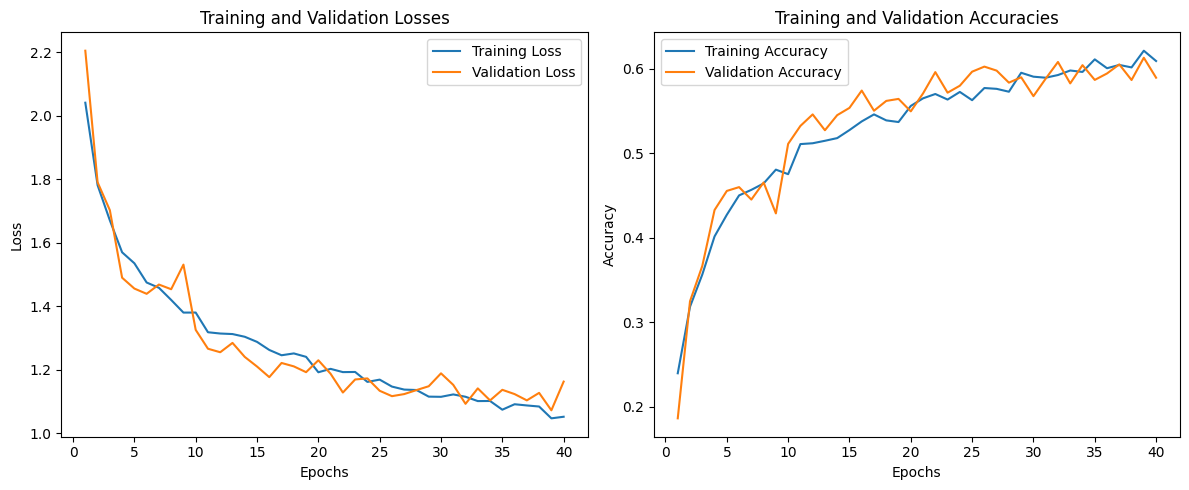

In [44]:
best_accuracy = 0
best_hyperparameters = {}
best_train_losses, best_val_losses, best_train_accuracy, best_val_accuracy = [], [], [], []

# Iterate over different parameters
for learning_rate in lr:
    for optimizer_name in optimizers:
        for reg in regularization:
            for batch_size_val in batch_size:

                print("*" * 100)
                print(f"Testing hyperparameters: learning_rate={learning_rate}, optimizer={optimizer_name}, regularization={reg}, batch_size={batch_size_val}")

                # Initialize the model
                model = CNN().to(device)

                # Train the model
                trained_model, train_losses, val_losses, train_accuracy, val_accuracy = train_network(model, device, batch_size_val, optimizer_name, learning_rate, reg)

                # Evaluate on validation set
                val_acc, val_loss = test(trained_model, device)

                # Update best accuracy and hyperparameters if current model has higher accuracy
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_hyperparameters = {
                        "learning_rate": learning_rate,
                        "optimizer": optimizer_name,
                        "regularization": reg,
                        "batch_size": batch_size_val
                    }
                    best_train_losses = train_losses
                    best_val_losses = val_losses
                    best_train_accuracy = train_accuracy
                    best_val_accuracy = val_accuracy

# Print the best hyperparameters and accuracy
print("Best hyperparameters:", best_hyperparameters)
print("Best validation accuracy:", best_accuracy)

# Plot the best graph
epochs_range = range(1, len(best_train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, best_train_losses, label='Training Loss')
plt.plot(epochs_range, best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, best_train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, best_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()



MobileNetV2_Fixed

****************************************************************************************************
Testing hyperparameters: learning_rate=0.0001, optimizer=Adams, regularization=0.0001, batch_size=128


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 182MB/s]


Epoch: 1	Train Loss: 2.3922	Accuracy: 0.1162 || Validation Loss: 2.2295	Accuracy: 0.2086
Epoch: 11	Train Loss: 1.8254	Accuracy: 0.3333 || Validation Loss: 1.6536	Accuracy: 0.4440
Epoch: 21	Train Loss: 1.7044	Accuracy: 0.3723 || Validation Loss: 1.4963	Accuracy: 0.5092
Epoch: 31	Train Loss: 1.5895	Accuracy: 0.4248 || Validation Loss: 1.4506	Accuracy: 0.5115
****************************************************************************************************
Testing hyperparameters: learning_rate=0.0001, optimizer=SGD, regularization=0.0001, batch_size=128
Epoch: 1	Train Loss: 2.6233	Accuracy: 0.1074 || Validation Loss: 2.3075	Accuracy: 0.1135
Epoch: 11	Train Loss: 2.2879	Accuracy: 0.1375 || Validation Loss: 2.2289	Accuracy: 0.2229
Epoch: 21	Train Loss: 2.2080	Accuracy: 0.1743 || Validation Loss: 2.1561	Accuracy: 0.2791
Epoch: 31	Train Loss: 2.1289	Accuracy: 0.2026 || Validation Loss: 2.0520	Accuracy: 0.3230
*********************************************************************************

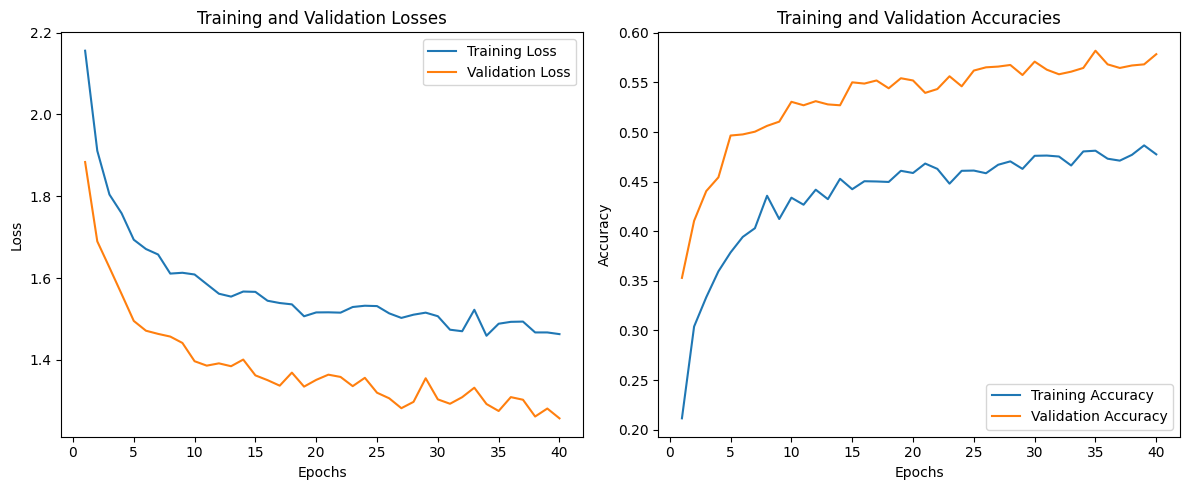

In [11]:
best_accuracy = 0
best_hyperparameters = {}
best_train_losses, best_val_losses, best_train_accuracy, best_val_accuracy = [], [], [], []

# Iterate over different parameters
for learning_rate in lr:
    for optimizer_name in optimizers:
        for reg in regularization:
            for batch_size_val in batch_size:

                print("*" * 100)
                print(f"Testing hyperparameters: learning_rate={learning_rate}, optimizer={optimizer_name}, regularization={reg}, batch_size={batch_size_val}")

                # Initialize the model
                model = MobileNetV2_Fixed().to(device)

                # Train the model
                trained_model, train_losses, val_losses, train_accuracy, val_accuracy = train_network(model, device, batch_size_val, optimizer_name, learning_rate, reg)

                # Evaluate on validation set
                val_acc, val_loss = test(trained_model, device)

                # Update best accuracy and hyperparameters if current model has higher accuracy
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_hyperparameters = {
                        "learning_rate": learning_rate,
                        "optimizer": optimizer_name,
                        "regularization": reg,
                        "batch_size": batch_size_val
                    }
                    best_train_losses = train_losses
                    best_val_losses = val_losses
                    best_train_accuracy = train_accuracy
                    best_val_accuracy = val_accuracy

# Print the best hyperparameters and accuracy
print("Best hyperparameters:", best_hyperparameters)
print("Best validation accuracy:", best_accuracy)

# Plot the best graph
epochs_range = range(1, len(best_train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, best_train_losses, label='Training Loss')
plt.plot(epochs_range, best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, best_train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, best_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


MobileNetV2_Learned

****************************************************************************************************
Testing hyperparameters: learning_rate=0.0001, optimizer=Adams, regularization=0.0001, batch_size=128
Epoch: 1	Train Loss: 2.3224	Accuracy: 0.1475 || Validation Loss: 2.1154	Accuracy: 0.2876
Epoch: 11	Train Loss: 0.7296	Accuracy: 0.7705 || Validation Loss: 0.5635	Accuracy: 0.8179
Epoch: 21	Train Loss: 0.4980	Accuracy: 0.8494 || Validation Loss: 0.5301	Accuracy: 0.8379
Epoch: 31	Train Loss: 0.3919	Accuracy: 0.8848 || Validation Loss: 0.5499	Accuracy: 0.8456
****************************************************************************************************
Testing hyperparameters: learning_rate=0.0001, optimizer=SGD, regularization=0.0001, batch_size=128
Epoch: 1	Train Loss: 2.5458	Accuracy: 0.1006 || Validation Loss: 2.3016	Accuracy: 0.1226
Epoch: 11	Train Loss: 2.2663	Accuracy: 0.1453 || Validation Loss: 2.1874	Accuracy: 0.2799
Epoch: 21	Train Loss: 2.0293	Accuracy: 0.2368 || Validatio

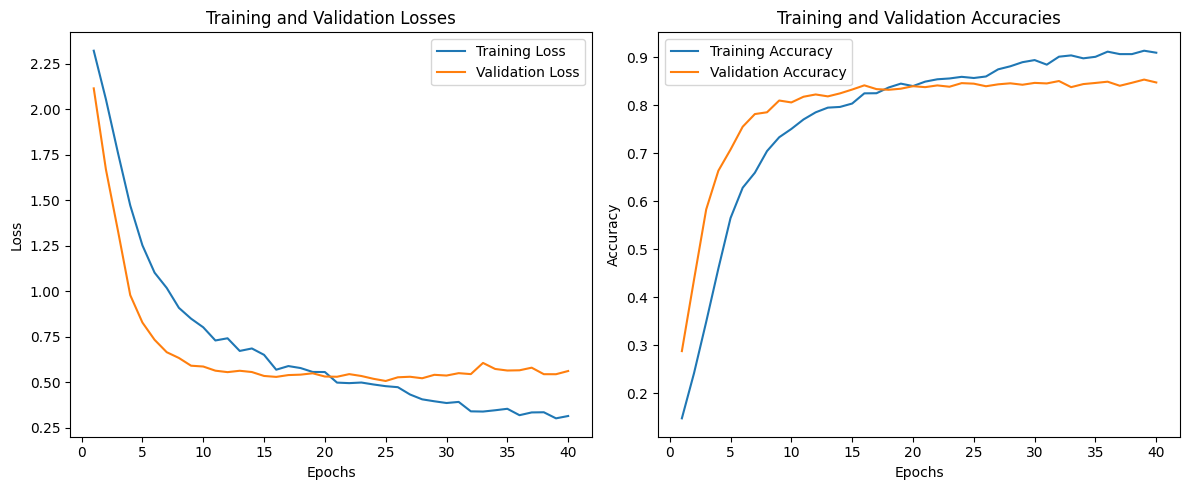

In [12]:
best_accuracy = 0
best_hyperparameters = {}
best_train_losses, best_val_losses, best_train_accuracy, best_val_accuracy = [], [], [], []

# Iterate over different parameters
for learning_rate in lr:
    for optimizer_name in optimizers:
        for reg in regularization:
            for batch_size_val in batch_size:

                print("*" * 100)
                print(f"Testing hyperparameters: learning_rate={learning_rate}, optimizer={optimizer_name}, regularization={reg}, batch_size={batch_size_val}")

                # Initialize the model
                model = MobileNetV2_Learned().to(device)

                # Train the model
                trained_model, train_losses, val_losses, train_accuracy, val_accuracy = train_network(model, device, batch_size_val, optimizer_name, learning_rate, reg)

                # Evaluate on validation set
                val_acc, val_loss = test(trained_model, device)

                # Update best accuracy and hyperparameters if current model has higher accuracy
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_hyperparameters = {
                        "learning_rate": learning_rate,
                        "optimizer": optimizer_name,
                        "regularization": reg,
                        "batch_size": batch_size_val
                    }
                    best_train_losses = train_losses
                    best_val_losses = val_losses
                    best_train_accuracy = train_accuracy
                    best_val_accuracy = val_accuracy

# Print the best hyperparameters and accuracy
print("Best hyperparameters:", best_hyperparameters)
print("Best validation accuracy:", best_accuracy)

# Plot the best graph
epochs_range = range(1, len(best_train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, best_train_losses, label='Training Loss')
plt.plot(epochs_range, best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, best_train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, best_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


Learnable parameters for FCNN and CNN

FCNN:

In an Fully Connected Neural Network (FCNN), each layer consists of weights and biases, along with batch normalization parameters (mean and standard deviation) for each output. The total number of parameters in each layer is calculated as follows:

weights
+
biases
+
batchnorm
=
input size
×
output size
+
output size
+
output size
×
2
weights+biases+batchnorm=input size×output size+output size+output size×2


The FCNN comprises 5 layers:

Fully connected layer with
64
×
64
×
3
64×64×3 input neurons and an output layer of 256, including batch normalization:

64
×
64
×
3
×
256
+
256
+
256
×
2
=
3
,
146
,
496
64×64×3×256+256+256×2=3,146,496 parameters.

Fully connected layer with 256 input neurons and an output layer of 512, including batch normalization:
256
×
512
+
512
+
512
×
2
=
132
,
608
256×512+512+512×2=132,608 parameters.

Fully connected layer with 512 input neurons and an output layer of 128, including batch normalization:
512
×
128
+
128
+
128
×
2
=
65
,
920
512×128+128+128×2=65,920 parameters.

Fully connected layer with 128 input neurons and an output layer of 64, including batch normalization:
128
×
64
+
64
+
64
×
2
=
8
,
384
128×64+64+64×2=8,384 parameters.

Fully connected layer with 64 input neurons and an output layer of 10:
64
×
10
+
10
=
650
64×10+10=650 parameters.

In total, the FCNN has
3
,
146
,
496
+
132
,
608
+
65
,
920
+
8
,
384
+
650
=
3
,
354
,
058
3,146,496+132,608+65,920+8,384+650

= 3,354,058 parameters.

CNN:

In a Convolutional Neural Network (CNN), each convolutional layer introduces additional parameters based on the number of input and output filters, the kernel size, and batch normalization. The total number of parameters in each convolutional layer is calculated as follows:

input filters
×
kernel height
×
kernel width
×
output filters
+
output filters
+
output filters
×
2
input filters×kernel height×kernel width×output filters+output filters+output filters×2

The CNN consists of the following layers:

Convolutional layer with 8 filters, kernel size of 3, batch normalization, and max pooling:
3
×
3
×
3
×
8
+
8
+
2
×
8
=
240
3×3×3×8+8+2×8=240 parameters.

Convolutional layer with 32 filters, kernel size of 3, batch normalization, and max pooling:
8
×
3
×
3
×
32
+
32
+
2
×
32
=
2
,
400
8×3×3×32+32+2×32=2,400 parameters.

Convolutional layer with 64 filters, kernel size of 3, batch normalization, and max pooling:
32
×
3
×
3
×
64
+
64
+
2
×
64
=
18
,
624
32×3×3×64+64+2×64=18,624 parameters.

Fully connected layer, input of
64
×
6
×
6
64×6×6, output of 128:
64
×
6
×
6
×
128
+
128
=
295
,
040
64×6×6×128+128=295,040 parameters.

Fully connected layer, input of 128, output of 10:
128
×
10
+
10
=
1
,
290
128×10+10=1,290 parameters.

The total number of parameters in the CNN is
317,
594
which is significantly fewer compared to the FCNN.